## Setup

In [46]:
%matplotlib inline

In [47]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [48]:
from aif360.datasets import StandardDataset
StandardDataset??

In [49]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [50]:
import os
import shutil
import glob

## Arguments & Initializations

In [51]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [52]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [53]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [54]:
DATASET = "german_age"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [55]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [56]:
ATTACK

'mia1'

## Loading & Splitting Dataset

In [57]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [58]:
dataset_orig.features.shape

(1000, 57)

In [59]:
privileged_groups

[{'age': 1}]

In [60]:
sens_attr

'age'

In [61]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [62]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[1.500e+01 2.631e+03 3.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [1.800e+01 4.297e+03 4.000e+00 ... 1.000e+00 1.000e+00 0.000e+00]
 [1.200e+01 2.073e+03 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 ...
 [1.200e+01 1.037e+03 3.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [9.000e+00 2.301e+03 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [1.800e+01 2.864e+03 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [63]:
seed = 1234
np.random.seed(seed)

In [64]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [65]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [66]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [67]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [68]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [69]:
target_dataset = None
reference_dataset = None

In [70]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

#### Train dataset's features are as below:
[[1.200e+01 2.279e+03 4.000e+00 ... 1.000e+00 1.000e+00 0.000e+00]
 [1.200e+01 3.565e+03 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [1.200e+01 1.282e+03 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 ...
 [3.600e+01 2.273e+03 3.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [1.500e+01 1.512e+03 3.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [1.000e+01 1.275e+03 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]
no bias type specified
#### Training Dataset shape
(500, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'cr

RUN DIRMITIGATOR
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 38
Number of test samples (ntest): 42
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 50
Number of test samples (ntest): 60
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 120
Number of test samples (ntest): 100
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 292
Number of test samples (ntest): 298
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       158
         1.0       0.99      0.94      0.97       342

    accuracy                           0.96       500
   macro avg       0.94      0.96      0.95       500
weighted avg       0.96      0.96      0.96       500

Train accuracy:  0.956
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 38
Number of test samples (ntest): 42
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 50
Number of test samples (ntest): 60
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 120
Number of test samples (ntest): 100
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 292
Number of test samples (ntest): 298
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.75      0.61      0.68       158
         1.0       0.84      0.91      0.87       342

    accuracy                           0.81       500
   macro avg       0.79      0.76      0.77       500
weighted avg       0.81      0.81      0.81       500

Train accuracy:  0.814
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.15000000000000002
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       152
         1.0       0.99      0.99      0.99       390

    accuracy                           0.99       542
   macro avg       0.98      0.98      0.98       542
weighted avg       0.99      0.99      0.99       542

Train accuracy:  0.985239852398524
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.01
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.67
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.30
  Positive predictive value: 0.60
  Optimal thershold: -0.9808292530117262
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 152, Test = 148
  AUC: 0.77
  Privacy Risk: 0.77
  Accuracy: 0.77
  Train Accuracy (TPR): 0.97
  Test 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 39
Number of test samples (ntest): 41
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 58
Number of test samples (ntest): 52
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 113
Number of test samples (ntest): 107
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 290
Number of test samples (ntest): 300
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.70       152
         1.0       0.86      0.89      0.87       348

    accuracy                           0.82       500
   macro avg       0.79      0.78      0.79       500
weighted avg       0.82      0.82      0.82       500

Train accuracy:  0.822
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

origin, transf:  500 519
after transf priv:  0.720873786407767
after transf unpriv:  0.719626168224299
Difference in mean outcomes between unprivileged and privileged groups = -0.001248
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 30
Number of test samples (ntest): 50
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 58
Number of test samples (ntest): 52
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 115
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 297
Number of test samples (ntest): 293
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       145
         1.0       0.97      0.97      0.97       374

    accuracy                           0.96       519
   macro avg       0.95      0.95      0.95       519
weighted avg      

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 30
Number of test samples (ntest): 50
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 58
Number of test samples (ntest): 52
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 115
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 297
Number of test samples (ntest): 293
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.76      0.64      0.70       145
         1.0       0.86      0.92      0.89       355

    accuracy                           0.84       500
   macro avg       0.81      0.78      0.79       500
weighted avg       0.83      0.84      0.83       500

Train accuracy:  0.838
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.24000000000000002
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Best thresh:  0.4
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.65
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.28
  Positive predictive value: 0.59
  Optimal thershold: -0.4418327522790392
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 132, Test = 168
  AUC: 0.75
  Privacy Risk: 0.73
  Accuracy: 0.70
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.46
  Positive predictive value: 0.62
  Optimal thershold: -1.0296194171811583
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 368, Test = 332
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.61
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.18
  Positive predictive value: 0.58
  Optimal thershold: -0.4418327522790392
)
MIA_Result(
  Name: subpopulation_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 31
Number of test samples (ntest): 49
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 58
Number of test samples (ntest): 52
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 101
Number of test samples (ntest): 119
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 310
Number of test samples (ntest): 280
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.71      0.61      0.66       132
         1.0       0.87      0.91      0.89       368

    accuracy                           0.83       500
   macro avg       0.79      0.76      0.77       500
weighted avg       0.83      0.83      0.83       500

Train accuracy:  0.832
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.19
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.65
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.28
  Positive predictive value: 0.60
  Optimal thershold: -0.33024168687057687
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 145, Test = 155
  AUC: 0.77
  Privacy Risk: 0.72
  Accuracy: 0.71
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.43
  Positive predictive value: 0.71
  Optimal thershold: -0.2231435513142097
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 355, Test = 345
  AUC: 0.60
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.20
  Positive predictive value: 0.57
  Optimal thershold: -0.33024168687057687
)
MIA_Result(
  Name: subpopulation_0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 41
Number of test samples (ntest): 39
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 54
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 104
Number of test samples (ntest): 116
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 301
Number of test samples (ntest): 289
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.63      0.67       145
         1.0       0.86      0.90      0.88       355

    accuracy                           0.82       500
   macro avg       0.79      0.76      0.77       500
weighted avg       0.82      0.82      0.82       500

Train accuracy:  0.822
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 44
Number of test samples (ntest): 36
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 105
Number of test samples (ntest): 115
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 294
Number of test samples (ntest): 296
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       149
         1.0       0.98      0.92      0.95       417

    accuracy                           0.93       566
   macro avg       0.89      0.93      0.91       566
weighted avg       0.93      0.93      0.93       566

Train accuracy:  0.9257950530035336
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 44
Number of test samples (ntest): 36
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 105
Number of test samples (ntest): 115
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 294
Number of test samples (ntest): 296
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.64      0.68       149
         1.0       0.86      0.90      0.88       351

    accuracy                           0.82       500
   macro avg       0.79      0.77      0.78       500
weighted avg       0.82      0.82      0.82       500

Train accuracy:  0.822
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.02
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.65
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.29
  Positive predictive value: 0.59
  Optimal thershold: -0.3677247801253174
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 154, Test = 146
  AUC: 0.82
  Privacy Risk: 0.77
  Accuracy: 0.77
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.54
  Positive predictive value: 0.77
  Optimal thershold: -0.3677247801253174
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 346, Test = 354
  AUC: 0.59
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.18
  Positive predictive value: 0.55
  Optimal thershold: -0.2876820724517809
)
MIA_Result(
  Name: subpopulation_0.

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 38
Number of test samples (ntest): 42
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 54
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 116
Number of test samples (ntest): 104
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 292
Number of test samples (ntest): 298
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       154
         1.0       0.87      0.91      0.89       346

    accuracy                           0.84       500
   macro avg       0.82      0.79      0.80       500
weighted avg       0.83      0.84      0.84       500

Train accuracy:  0.838
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 121
Number of test samples (ntest): 99
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 285
Number of test samples (ntest): 305
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       158
         1.0       0.99      0.99      0.99       372

    accuracy                           0.99       530
   macro avg       0.99      0.99      0.99       530
weighted avg       0.99      0.99      0.99       530

Train accuracy:  0.9886792452830189
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.17
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.64
  Privacy Risk: 0.65
  Accuracy: 0.65
  Tra

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 37
Number of test samples (ntest): 43
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 121
Number of test samples (ntest): 99
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 285
Number of test samples (ntest): 305
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.78      0.60      0.68       158
         1.0       0.83      0.92      0.88       342

    accuracy                           0.82       500
   macro avg       0.81      0.76      0.78       500
weighted avg       0.82      0.82      0.81       500

Train accuracy:  0.82
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Data

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 45
Number of test samples (ntest): 35
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 51
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 131
Number of test samples (ntest): 89
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 265
Number of test samples (ntest): 325
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94       176
         1.0       0.96      0.98      0.97       356

    accuracy                           0.96       532
   macro avg       0.96      0.95      0.95       532
weighted avg       0.96      0.96      0.96       532

Train accuracy:  0.9605263157894737
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.01
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 45
Number of test samples (ntest): 35
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 51
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 131
Number of test samples (ntest): 89
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 265
Number of test samples (ntest): 325
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71       176
         1.0       0.83      0.89      0.86       324

    accuracy                           0.81       500
   macro avg       0.80      0.78      0.79       500
weighted avg       0.81      0.81      0.81       500

Train accuracy:  0.812
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.42000000000000004
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 115
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 291
Number of test samples (ntest): 299
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.87       152
         1.0       0.92      0.99      0.96       384

    accuracy                           0.93       536
   macro avg       0.95      0.89      0.91       536
weighted avg       0.94      0.93      0.93       536

Train accuracy:  0.9347014925373134
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.17
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.62
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.23
  Positive predictive value: 0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 37
Number of test samples (ntest): 43
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 115
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 291
Number of test samples (ntest): 299
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.63      0.69       152
         1.0       0.85      0.92      0.88       348

    accuracy                           0.83       500
   macro avg       0.81      0.77      0.79       500
weighted avg       0.83      0.83      0.82       500

Train accuracy:  0.83
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.36000000000000004
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 42
Number of test samples (ntest): 38
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 48
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 108
Number of test samples (ntest): 112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 302
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87       150
         1.0       0.93      0.99      0.96       400

    accuracy                           0.94       550
   macro avg       0.95      0.89      0.91       550
weighted avg       0.94      0.94      0.93       550

Train accuracy:  0.9363636363636364
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.19
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 42
Number of test samples (ntest): 38
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 48
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 108
Number of test samples (ntest): 112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 302
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.61      0.66       150
         1.0       0.84      0.90      0.87       350

    accuracy                           0.81       500
   macro avg       0.78      0.75      0.76       500
weighted avg       0.81      0.81      0.81       500

Train accuracy:  0.812
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 36
Number of test samples (ntest): 44
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 108
Number of test samples (ntest): 112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 291
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       144
         1.0       0.97      0.98      0.98       398

    accuracy                           0.96       542
   macro avg       0.96      0.95      0.95       542
weighted avg       0.96      0.96      0.96       542

Train accuracy:  0.9649446494464945
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 36
Number of test samples (ntest): 44
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 53
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 108
Number of test samples (ntest): 112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 291
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65       144
         1.0       0.85      0.89      0.87       356

    accuracy                           0.81       500
   macro avg       0.77      0.75      0.76       500
weighted avg       0.80      0.81      0.81       500

Train accuracy:  0.81
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.05
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       144
         1.0       0.98      0.95      0.96       410

    accuracy                           0.95       554
   macro avg       0.92      0.95      0.93       554
weighted avg       0.95      0.95      0.95       554

Train accuracy:  0.9458483754512635
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.63
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.23
  Positive predictive value: 0.58
  Optimal thershold: -0.6931471805599453
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 144, Test = 156
  AUC: 0.74
  Privacy Risk: 0.71
  Accuracy: 0.70
  Train Accuracy (TPR): 0.94
  Test 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 37
Number of test samples (ntest): 43
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 51
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 107
Number of test samples (ntest): 113
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 305
Number of test samples (ntest): 285
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.74      0.65      0.69       144
         1.0       0.86      0.91      0.89       356

    accuracy                           0.83       500
   macro avg       0.80      0.78      0.79       500
weighted avg       0.83      0.83      0.83       500

Train accuracy:  0.834
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

origin, transf:  500 568
after transf priv:  0.7292682926829268
after transf unpriv:  0.7278481012658228
Difference in mean outcomes between unprivileged and privileged groups = -0.001420
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 43
Number of test samples (ntest): 37
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 47
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 111
Number of test samples (ntest): 109
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 291
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       154
         1.0       0.98      0.99      0.99       414

    accuracy                           0.98       568
   macro avg       0.98      0.97      0.98       568
weighted avg    

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 43
Number of test samples (ntest): 37
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 47
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 111
Number of test samples (ntest): 109
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 291
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68       154
         1.0       0.85      0.89      0.87       346

    accuracy                           0.82       500
   macro avg       0.79      0.77      0.78       500
weighted avg       0.81      0.82      0.81       500

Train accuracy:  0.816
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 92
Number of test samples (ntest): 128
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 317
Number of test samples (ntest): 273
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       127
         1.0       1.00      0.99      0.99       437

    accuracy                           0.99       564
   macro avg       0.98      0.99      0.98       564
weighted avg       0.99      0.99      0.99       564

Train accuracy:  0.9893617021276596
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.34
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.35
  Positive predictive value: 0.

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 35
Number of test samples (ntest): 45
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 56
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 92
Number of test samples (ntest): 128
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 317
Number of test samples (ntest): 273
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.67      0.55      0.61       127
         1.0       0.86      0.91      0.88       373

    accuracy                           0.82       500
   macro avg       0.76      0.73      0.74       500
weighted avg       0.81      0.82      0.81       500

Train accuracy:  0.818
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.11
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       155
         1.0       0.96      0.97      0.96       374

    accuracy                           0.95       529
   macro avg       0.94      0.93      0.94       529
weighted avg       0.95      0.95      0.95       529

Train accuracy:  0.947069943289225
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.4
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.66
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.27
  Positive predictive value: 0.64
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 155, Test = 145
  AUC: 0.77
  Privacy Risk: 0.74
  Accuracy: 0.75
  Train Accuracy (TPR): 0.89
  Test A

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 37
Number of test samples (ntest): 43
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 60
Number of test samples (ntest): 50
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 118
Number of test samples (ntest): 102
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 285
Number of test samples (ntest): 305
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.61      0.66       155
         1.0       0.84      0.90      0.86       345

    accuracy                           0.81       500
   macro avg       0.78      0.75      0.76       500
weighted avg       0.80      0.81      0.80       500

Train accuracy:  0.806
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.17
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91       145
         1.0       0.97      0.98      0.97       426

    accuracy                           0.96       571
   macro avg       0.95      0.94      0.94       571
weighted avg       0.96      0.96      0.96       571

Train accuracy:  0.9562171628721541
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.67
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.30
  Positive predictive value: 0.61
  Optimal thershold: -0.8754687373539001
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 145, Test = 155
  AUC: 0.81
  Privacy Risk: 0.76
  Accuracy: 0.75
  Train Accuracy (TP

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 41
Number of test samples (ntest): 39
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 104
Number of test samples (ntest): 116
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 306
Number of test samples (ntest): 284
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65       145
         1.0       0.85      0.88      0.86       355

    accuracy                           0.80       500
   macro avg       0.76      0.75      0.76       500
weighted avg       0.80      0.80      0.80       500

Train accuracy:  0.804
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.47000000000000003
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 291
Number of test samples (ntest): 299
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       156
         1.0       0.99      0.99      0.99       388

    accuracy                           0.98       544
   macro avg       0.98      0.98      0.98       544
weighted avg       0.98      0.98      0.98       544

Train accuracy:  0.9834558823529411
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.64
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.30
  Positive predictive value: 0.59
  Optimal thershold: -1.3862943611198906
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Datase

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 39
Number of test samples (ntest): 41
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 117
Number of test samples (ntest): 103
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 291
Number of test samples (ntest): 299
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66       156
         1.0       0.85      0.84      0.84       344

    accuracy                           0.79       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.79      0.79      0.79       500

Train accuracy:  0.786
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.11
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

origin, transf:  500 518
after transf priv:  0.7012345679012346
after transf unpriv:  0.6991150442477876
Difference in mean outcomes between unprivileged and privileged groups = -0.002120
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 34
Number of test samples (ntest): 46
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 121
Number of test samples (ntest): 99
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 284
Number of test samples (ntest): 306
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       155
         1.0       0.99      0.99      0.99       363

    accuracy                           0.98       518
   macro avg       0.98      0.98      0.98       518
weighted avg     

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 34
Number of test samples (ntest): 46
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 121
Number of test samples (ntest): 99
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 284
Number of test samples (ntest): 306
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.70       155
         1.0       0.86      0.88      0.87       345

    accuracy                           0.82       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.82      0.82      0.82       500

Train accuracy:  0.818
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.47000000000000003
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.66
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.29
  Positive predictive value: 0.60
  Optimal thershold: -0.40546510810816444
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 148, Test = 152
  AUC: 0.77
  Privacy Risk: 0.75
  Accuracy: 0.74
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.49
  Positive predictive value: 0.69
  Optimal thershold: -0.15415067982725822
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 352, Test = 348
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.20
  Positive predictive value: 0.57
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 36
Number of test samples (ntest): 44
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 112
Number of test samples (ntest): 108
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 291
Number of test samples (ntest): 299
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.69      0.55      0.61       148
         1.0       0.83      0.90      0.86       352

    accuracy                           0.79       500
   macro avg       0.76      0.72      0.74       500
weighted avg       0.79      0.79      0.79       500

Train accuracy:  0.794
Validating EG ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.03
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

In [71]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [28]:
df_bank['age'].value_counts()

age
1.0    810
0.0    190
Name: count, dtype: int64

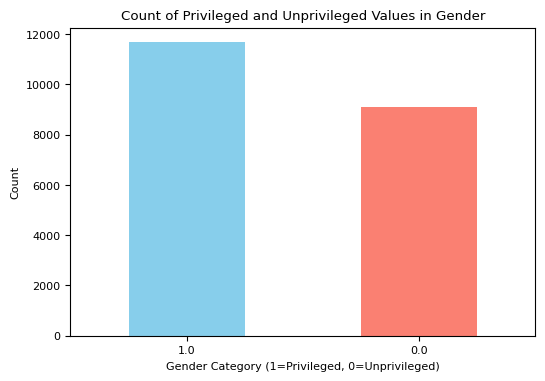

In [74]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [75]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [76]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'y'

In [77]:
df_bank.shape

(20798, 14)

## Display Output

In [72]:
priv_metric_orig_copy = priv_metric_orig

In [73]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 8121.0, 'total_unpriv': 1879.0})

In [74]:
priv_metric_orig

defaultdict(float, {'total_priv': 8121.0, 'total_unpriv': 1879.0})

In [75]:
priv_metric_orig.items()

dict_items([('total_priv', 8121.0), ('total_unpriv', 1879.0)])

In [76]:
priv_metric_orig = priv_metric_orig_copy

In [77]:
orig_metrics.items()

dict_items([('bal_acc', [0.6201117318435754, 0.6155175061425061, 0.6243571762505844, 0.6268646012621917, 0.6506778868630201, 0.6395567278316476, 0.618082965714728, 0.6185380439058935, 0.6092141386410432, 0.625115171990172, 0.6514285714285715, 0.6203041144901611, 0.649448419797257, 0.6121817196811392, 0.5755687543087448, 0.589800874210782, 0.5897148200093502, 0.6730259051186017, 0.579504613890238, 0.6181941923774954]), ('avg_odds_diff', [-0.13806008309364018, -0.12127483298556924, -0.10773037542662114, -0.0807103610675039, -0.0862855947496802, -0.06861458464206616, -0.05507872999483743, -0.05281321548882101, -0.11796605245382513, 0.017778506413872852, 0.07039172849341893, 0.04731130286104998, -0.1280988337364038, -0.07280112529332242, -0.011626856939356944, -0.14207739977424444, -0.061807051379022426, -0.06482418605227608, 0.10050897829487526, -0.027982541957697282]), ('disp_imp', [0.2692440933970761, 0.20060587902393556, 0.2039477998557282, 0.17315219894082434, 0.22900335946248596, 0.1

In [78]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

german_age
500
2)

              total_priv  total_unpriv
num_instance                          
orig              406.05         93.95
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.700100       0.299900    0.724188      0.275812      0.595649   
transf      0.723978       0.276022    0.724188      0.275812      0.723342   

         unpriv_unfavor  
dataset                  
orig           0.404351  
transf         0.276658  


In [79]:
orig_metrics.items()

dict_items([('bal_acc', [0.6201117318435754, 0.6155175061425061, 0.6243571762505844, 0.6268646012621917, 0.6506778868630201, 0.6395567278316476, 0.618082965714728, 0.6185380439058935, 0.6092141386410432, 0.625115171990172, 0.6514285714285715, 0.6203041144901611, 0.649448419797257, 0.6121817196811392, 0.5755687543087448, 0.589800874210782, 0.5897148200093502, 0.6730259051186017, 0.579504613890238, 0.6181941923774954]), ('avg_odds_diff', [-0.13806008309364018, -0.12127483298556924, -0.10773037542662114, -0.0807103610675039, -0.0862855947496802, -0.06861458464206616, -0.05507872999483743, -0.05281321548882101, -0.11796605245382513, 0.017778506413872852, 0.07039172849341893, 0.04731130286104998, -0.1280988337364038, -0.07280112529332242, -0.011626856939356944, -0.14207739977424444, -0.061807051379022426, -0.06482418605227608, 0.10050897829487526, -0.027982541957697282]), ('disp_imp', [0.2692440933970761, 0.20060587902393556, 0.2039477998557282, 0.17315219894082434, 0.22900335946248596, 0.1

In [80]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

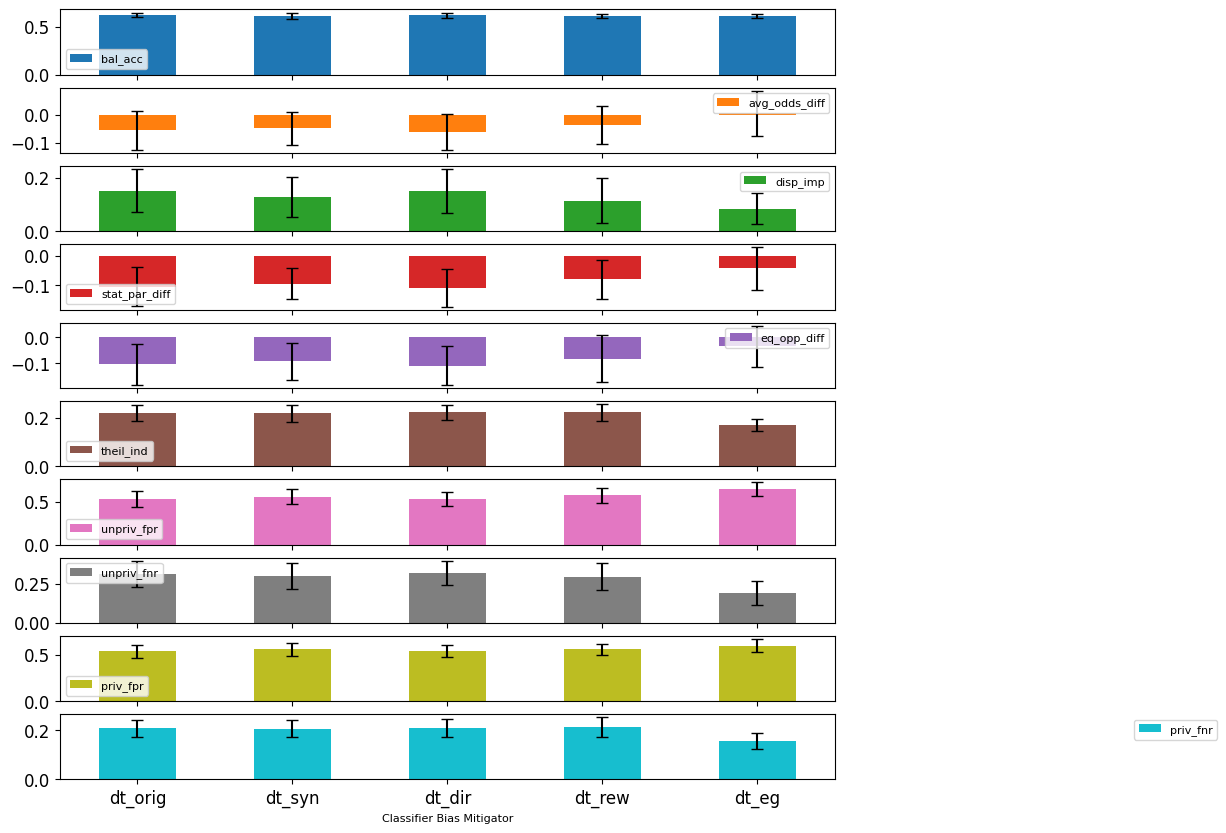

In [81]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [82]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [83]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.64480,0.737741,0.605814,0.737380,0.650751,0.743319,0.599477
syn,0.64725,0.746163,0.606302,0.748607,0.648359,0.749670,0.600864
dir,0.64610,0.742797,0.607110,0.743699,0.658351,0.747103,0.599885
rew,0.65030,0.748967,0.609345,0.737628,0.656423,0.758188,0.603685
eg,0.57230,0.627087,0.555299,0.665955,0.610166,0.623747,0.550487


In [84]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [85]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [86]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.737380,0.650751,0.743319,0.599477
syn,0.748607,0.648359,0.749670,0.600864
dir,0.743699,0.658351,0.747103,0.599885
rew,0.737628,0.656423,0.758188,0.603685
eg,0.665955,0.610166,0.623747,0.550487


<Axes: xlabel='Classifier MIA Attacks'>

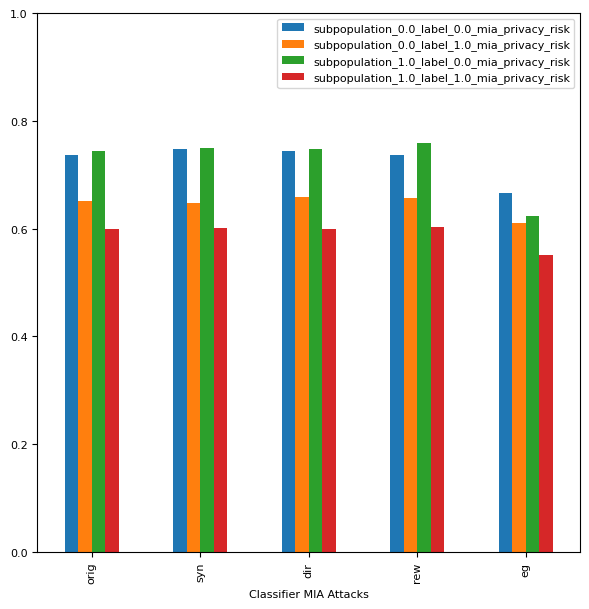

In [87]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [88]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.73738   0.748607  0.743699  0.737628  0.665955
subpopulation_0.0_label_1.0_mia_privacy_risk  0.650751  0.648359  0.658351  0.656423  0.610166
subpopulation_1.0_label_0.0_mia_privacy_risk  0.743319  0.74967   0.747103  0.758188  0.623747
subpopulation_1.0_label_1.0_mia_privacy_risk  0.599477  0.600864  0.599885  0.603685  0.550487


### Visualizing using novel technique

In [95]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


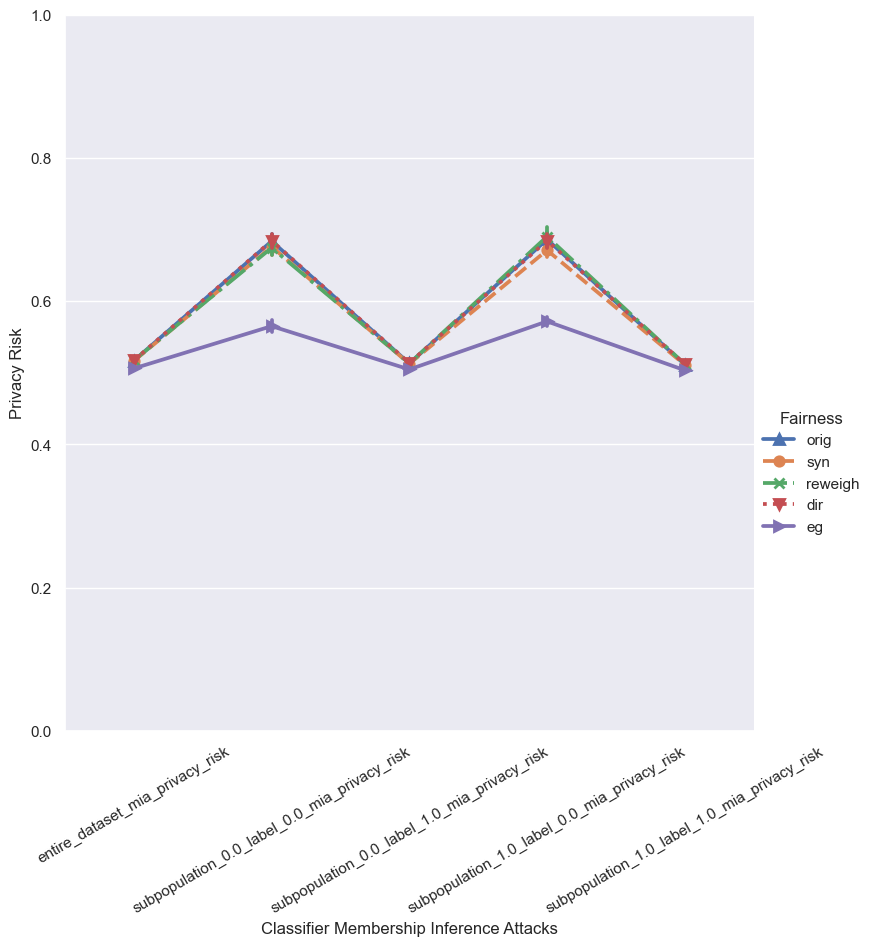

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr